In [1]:
# data managing and display libs
import pandas as pd
import numpy as np
import os
import io

import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline 

# sagemaker libraries
import boto3
import sagemaker

In [2]:
# boto3 client to get S3 data
s3_client = boto3.client('s3')
bucket_name='skuchkula-sagemaker-airbnb'

In [3]:
# list the bucket objects
response = s3_client.list_objects(Bucket=bucket_name)

# get list of objects inside the bucket
files = [file['Key'] for file in response['Contents']]
files

['clean/airbnb_clean.csv',
 'detailed_listings.csv',
 'feature_eng/amenities_features.csv',
 'feature_eng/description_features.csv',
 'feature_eng/host_verification_features.csv',
 'feature_eng/merged_features.csv',
 'feature_eng/min_max_scaled_final_df.csv',
 'feature_eng/scaled_final_df.csv',
 'summary_listings.csv']

In [4]:
# download the file from s3
def get_data_frame(bucket_name, file_name):
    '''
    Takes the location of the dataset on S3 and returns a dataframe.
    arguments:
            bucket_name: the name of the bucket
            file_name: the key inside the bucket
    returns:
            dataframe
    '''
    # get an S3 object by passing in the bucket and file name
    data_object = s3_client.get_object(Bucket=bucket_name, Key=file_name)
    
    # information is in the "Body" of the object
    data_body = data_object["Body"].read()
    
    # read in bytes data
    data_stream = io.BytesIO(data_body)
    
    # create a dataframe
    df = pd.read_csv(data_stream, header=0, delimiter=",", low_memory=False, keep_default_na=False)
    
    return df

In [5]:
file = 'feature_eng/min_max_scaled_final_df.csv'
df_airbnb = get_data_frame(bucket_name, file)

In [6]:
from sagemaker import get_execution_role

session = sagemaker.Session() # store the current SageMaker session

# get IAM role
role = get_execution_role()
print(role)

arn:aws:iam::506140549518:role/service-role/AmazonSageMaker-ExecutionRole-20190827T125122


In [7]:
# get default bucket
bucket_name = session.default_bucket()
print(bucket_name)
print()

sagemaker-us-east-1-506140549518



In [8]:
# define location to store model artifacts
prefix = 'pca'

output_path='s3://{}/{}/'.format(bucket_name, prefix)

print('Training artifacts will be uploaded to: {}'.format(output_path))

Training artifacts will be uploaded to: s3://sagemaker-us-east-1-506140549518/pca/


In [9]:
# define a PCA model
from sagemaker import PCA

# this is current features - 1
# you'll select only a portion of these to use, later
N_COMPONENTS=50

pca_SM = PCA(role=role,
             train_instance_count=1,
             train_instance_type='ml.c4.xlarge',
             output_path=output_path, # specified, above
             num_components=N_COMPONENTS, 
             sagemaker_session=session)

In [10]:
# convert df to np array
train_data_np = df_airbnb.values.astype('float32')

# convert to RecordSet format
formatted_train_data = pca_SM.record_set(train_data_np)

In [11]:
%%time

# train the PCA mode on the formatted data
pca_SM.fit(formatted_train_data)

2019-10-08 18:42:34 Starting - Starting the training job...
2019-10-08 18:42:49 Starting - Launching requested ML instances......
2019-10-08 18:43:54 Starting - Preparing the instances for training......
2019-10-08 18:45:01 Downloading - Downloading input data...
2019-10-08 18:45:29 Training - Downloading the training image...
2019-10-08 18:46:03 Uploading - Uploading generated training modelDocker entrypoint called with argument(s): train
[10/08/2019 18:45:50 INFO 140361499367232] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-conf.json: {u'_num_gpus': u'auto', u'_log_level': u'info', u'subtract_mean': u'true', u'force_dense': u'true', u'epochs': 1, u'algorithm_mode': u'regular', u'extra_components': u'-1', u'_kvstore': u'dist_sync', u'_num_kv_servers': u'auto'}
[10/08/2019 18:45:50 INFO 140361499367232] Reading provided configuration from /opt/ml/input/config/hyperparameters.json: {u'feature_dim': u'2201', u'mini_batch_size': u'


2019-10-08 18:46:09 Completed - Training job completed
Training seconds: 68
Billable seconds: 68
CPU times: user 492 ms, sys: 19 ms, total: 511 ms
Wall time: 4min 12s


In [12]:
training_job_name='pca-2019-10-08-18-42-34-408'

# where the model is saved, by default
model_key = os.path.join(prefix, training_job_name, 'output/model.tar.gz')
print(model_key)

# download and unzip model
boto3.resource('s3').Bucket(bucket_name).download_file(model_key, 'model.tar.gz')

# unzipping as model_algo-1
os.system('tar -zxvf model.tar.gz')
os.system('unzip model_algo-1')

pca/pca-2019-10-08-18-42-34-408/output/model.tar.gz


2304

In [13]:
import mxnet as mx

# loading the unzipped artifacts
pca_model_params = mx.ndarray.load('model_algo-1')

# what are the params
print(pca_model_params)

{'s': 
[ 57.05088   57.874645  58.433697  59.175858  59.865147  61.96779
  63.226593  64.11992   66.35956   67.24171   67.67469   68.12071
  69.39432   70.41575   71.05591   71.61029   72.413445  72.68548
  74.65268   77.155876  79.46062   80.077995  82.66995   85.92465
  86.539955  87.50056   88.780014  89.40145   90.21015   94.273415
  96.85173   97.366425 100.695    103.57861  105.91536  107.30245
 107.82814  109.70534  112.907974 116.73672  118.375206 121.84918
 129.90123  139.94371  151.06177  163.72157  169.06854  177.17932
 211.70601  311.55603 ]
<NDArray 50 @cpu(0)>, 'v': 
[[-5.7720104e-03 -5.3913011e-03  9.0847909e-03 ...  3.0375753e-02
  -1.0498090e-02 -1.1980495e-02]
 [-2.6859946e-03  5.4610777e-04  8.8122051e-04 ...  3.9079497e-03
   3.9688114e-04 -1.6078530e-03]
 [ 8.4759603e-04 -1.2613757e-03  2.8918835e-03 ...  9.3708942e-03
  -3.0037272e-03 -5.2033747e-03]
 ...
 [-4.3243897e-04 -1.7060355e-04 -2.5075878e-04 ... -1.8658712e-04
   1.1779055e-05 -1.6026984e-06]
 [-6.738512

In [14]:
# get selected params
s=pd.DataFrame(pca_model_params['s'].asnumpy())
v=pd.DataFrame(pca_model_params['v'].asnumpy())

In [15]:
# looking at top 20 components
n_principal_components = 20

start_idx = N_COMPONENTS - n_principal_components  # 50-n

# print a selection of s
print(s.iloc[start_idx:, :])

             0
30   96.851730
31   97.366425
32  100.695000
33  103.578613
34  105.915359
35  107.302452
36  107.828140
37  109.705338
38  112.907974
39  116.736717
40  118.375206
41  121.849182
42  129.901230
43  139.943710
44  151.061768
45  163.721573
46  169.068542
47  177.179321
48  211.706009
49  311.556030


In [16]:
# Calculate the explained variance for the top n principal components
# you may assume you have access to the global var N_COMPONENTS
def explained_variance(s, n_top_components):
    '''Calculates the approx. data variance that n_top_components captures.
       :param s: A dataframe of singular values for top components; 
           the top value is in the last row.
       :param n_top_components: An integer, the number of top components to use.
       :return: The expected data variance covered by the n_top_components.'''
    
    start_idx = N_COMPONENTS - n_top_components  ## 33-3 = 30, for example
    # calculate approx variance
    exp_variance = np.square(s.iloc[start_idx:,:]).sum()/np.square(s).sum()
    
    return exp_variance[0]

In [20]:
# test cell
n_top_components = 30 # select a value for the number of top components

# calculate the explained variance
exp_variance = explained_variance(s, n_top_components)
print('Explained variance: ', exp_variance)

Explained variance:  0.8496999


In [21]:
# features
features_list = df_airbnb.columns.values
print('Features: \n', features_list)

Features: 
 ['accommodates' 'bathrooms' 'bedrooms' ... 'description_contains_yummy'
 'description_contains_zero' 'description_contains_zone']


In [22]:
import seaborn as sns

def display_component(v, features_list, component_num, n_weights=10):
    
    # get index of component (last row - component_num)
    row_idx = N_COMPONENTS-component_num

    # get the list of weights from a row in v, dataframe
    v_1_row = v.iloc[:, row_idx]
    v_1 = np.squeeze(v_1_row.values)

    # match weights to features in counties_scaled dataframe, using list comporehension
    comps = pd.DataFrame(list(zip(v_1, features_list)), 
                         columns=['weights', 'features'])

    # we'll want to sort by the largest n_weights
    # weights can be neg/pos and we'll sort by magnitude
    comps['abs_weights']=comps['weights'].apply(lambda x: np.abs(x))
    sorted_weight_data = comps.sort_values('abs_weights', ascending=False).head(n_weights)

    # display using seaborn
    ax=plt.subplots(figsize=(10,6))
    ax=sns.barplot(data=sorted_weight_data, 
                   x="weights", 
                   y="features", 
                   palette="Blues_d")
    ax.set_title("PCA Component Makeup, Component #" + str(component_num))
    plt.show()

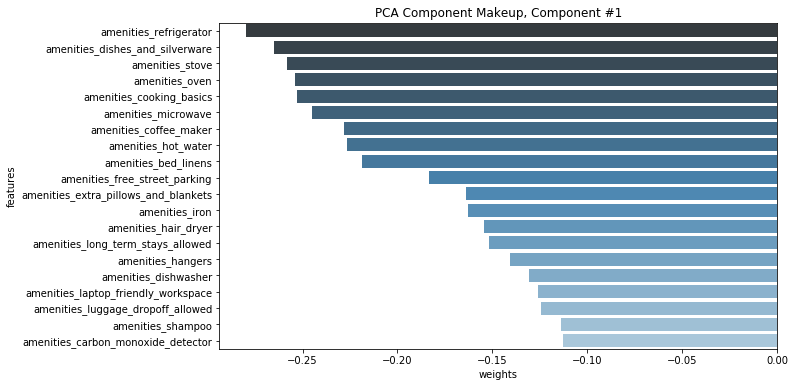

In [23]:
# display makeup of first component
num=1
display_component(v, df_airbnb.columns.values, component_num=num, n_weights=20)

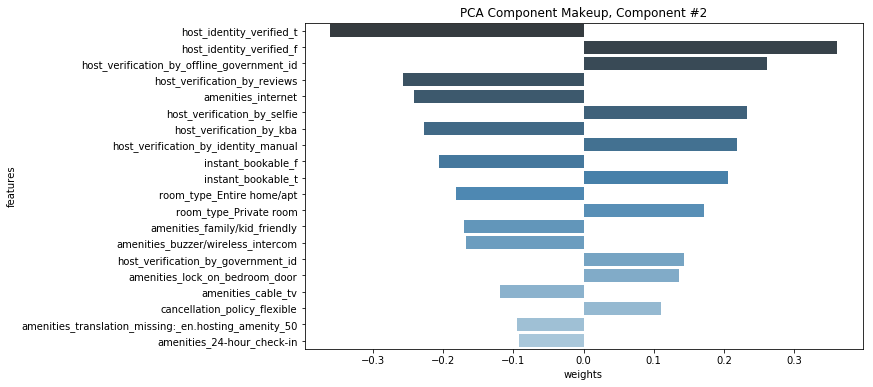

In [24]:
# display makeup of first component
num=2
display_component(v, df_airbnb.columns.values, component_num=num, n_weights=20)

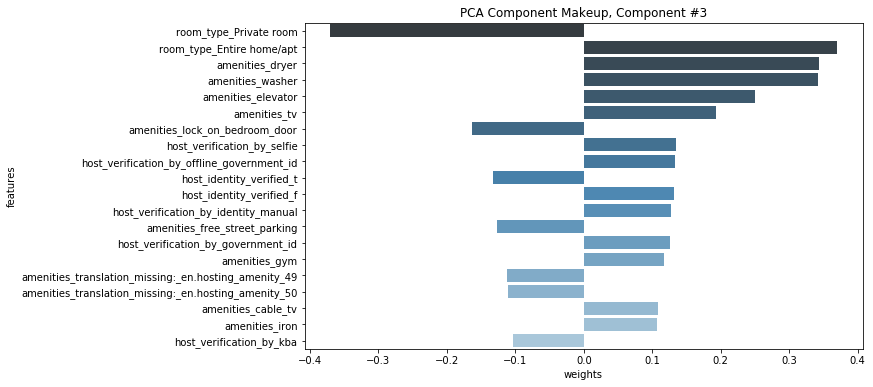

In [25]:
# display makeup of first component
num=3
display_component(v, df_airbnb.columns.values, component_num=num, n_weights=20)

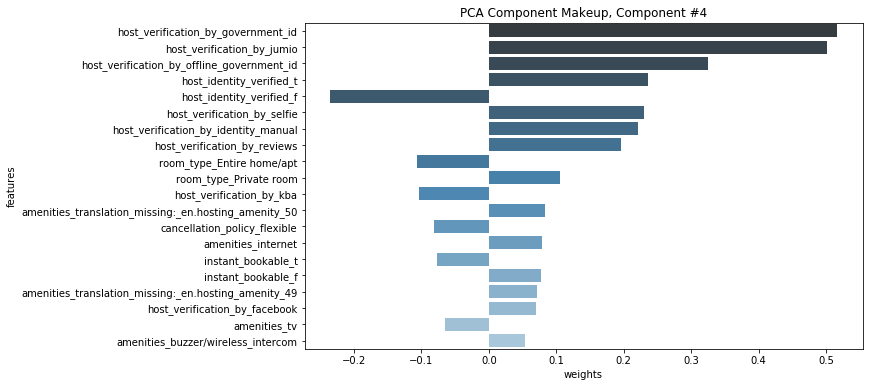

In [26]:
# display makeup of first component
num=4
display_component(v, df_airbnb.columns.values, component_num=num, n_weights=20)

## Deploy PCA

In [29]:
pca_predictor = pca_SM.deploy(initial_instance_count=1, instance_type='ml.t2.medium')

TypeError: create_model() got an unexpected keyword argument 'model_kms_key'

In [30]:
%%time
# this takes a little while, around 7mins
pca_predictor = pca_SM.deploy(initial_instance_count=1, 
                              instance_type='ml.c4.xlarge')

TypeError: create_model() got an unexpected keyword argument 'model_kms_key'

In [32]:
pca_SM.deploy()

TypeError: deploy() missing 2 required positional arguments: 'initial_instance_count' and 'instance_type'